# Using a Neural Network as a Regularizer

### Here we will try to use a nn with two inputs: the image (blurry or not) and the projection (exact one)

In [35]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.datasets as dsets
from skimage import transform
import torchvision.transforms as transforms
from torch.autograd import Variable
import pandas as pd;
import numpy as np;
from torch.utils.data import Dataset, DataLoader
import random
import h5py
import math
import torch.nn.functional as F
import scipy.io
import matplotlib.pyplot as plt

### First we will create the dataset to train our nn

We use our brain dataset, and we add random values to each pixel in order to blurry images. All the values add are summed to create our regulized norm we want to minimize

In [36]:
# First let's take a few images

number_brains_train = 100
brains = []
for i in range(1, 1+number_brains_train):
    with h5py.File('../../Brains/%s.mat' %i, 'r') as f:
        brain = np.array(f['cjdata']['image'])
        brain = brain[::8, ::8]
        brains += [brain]

In [37]:
# Pojection Matrix

mat_90 = scipy.io.loadmat('../thinL64_90')
A_90 = mat_90['H'].todense()
print(A_90)
print(A_90.shape)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(8100, 4096)


In [38]:
# Let's artificially blurry the images

resulting_brains = []
vars_ = []
projections_ = []


number_brains_blurried = 10

for l in range(len(brains)):
    test_brain = brains[l]/1000
    resulting_brains.append(test_brain)
    vars_.append(0)
    p_90 = np.transpose(np.matmul(A_90, test_brain.flatten()))
    projections_.append(p_90.reshape(90, 90))
    for i in range(number_brains_blurried):
        var = 0
        changed_brain = np.copy(test_brain)
        for j in range(64):
            for k in range(64):
                value = changed_brain[k][j]
                add = np.random.randint(max(-value, -1000+100*i), 1000-100*i)/1000
                #print(changed_brain[k][j])
                changed_brain[k][j] = value + add
                #print(changed_brain[k][j])

                var = var + add*add/1000
        resulting_brains.append(changed_brain)
        vars_.append(var)
        
        p_90 = np.transpose(np.matmul(A_90, test_brain.flatten()))
        projections_.append(p_90.reshape(90, 90))

In [39]:
def randomize(a, b, c):
    # Generate the permutation index array.
    permutation = np.random.permutation(a.shape[0])
    # Shuffle the arrays by giving the permutation in the square brackets.
    shuffled_a = a[permutation]
    shuffled_b = b[permutation]
    shuffled_c = c[permutation]
    return shuffled_a, shuffled_b, shuffled_c

resulting_brains, vars_, projections_ = randomize(np.array(resulting_brains), np.array(vars_), np.array(projections_))

print(vars_[:10])

[0.12274145 1.3790847  0.2163094  1.09960483 0.86028017 0.21817765
 0.66061911 0.85728406 0.05468602 0.85394702]


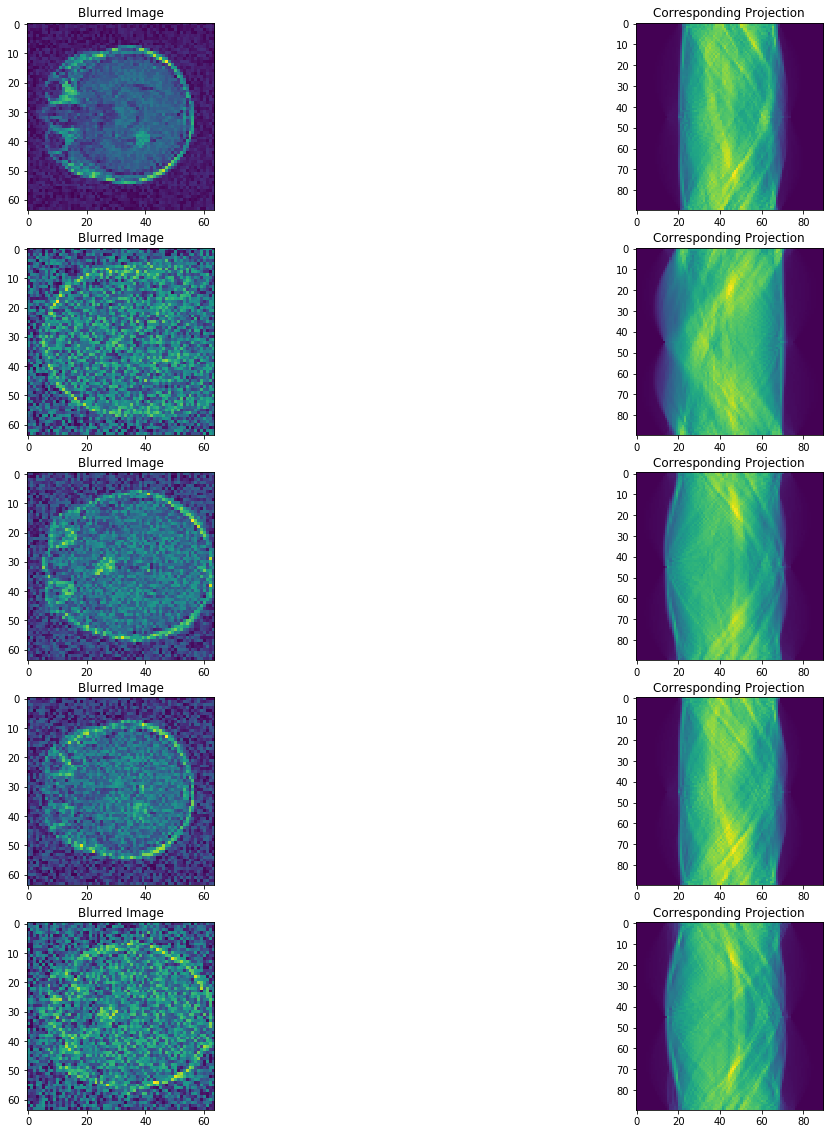

Scores:
[0.12274145 1.3790847  0.2163094  1.09960483 0.86028017]


In [40]:
columns = 2
rows = 5

fig=plt.figure(figsize=(20, 20))
for i in range(1, 6):
    brain = resulting_brains[i-1]
    fig.add_subplot(rows, columns, 2*i-1)
    plt.title('Blurred Image')
    plt.imshow(brain)
    
    P = projections_[i-1]
    fig.add_subplot(rows, columns, 2*i)
    plt.title('Corresponding Projection')
    plt.imshow(P)
    
plt.show()

print('Scores:')
print(vars_[:5])

Now that we have our data, let's build the network

In [76]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.features1 = nn.Sequential(
            nn.Conv2d(1, 3, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        self.features2 = nn.Sequential(
            nn.Conv2d(1, 3, 3, 1, 1),
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        self.classifier = nn.Linear(45*45*3 + 32*32*3, 1)
        
    def forward(self, x1, x2):
        x1 = self.features1(x1)
#         print('SHAPE', x1.shape)
        x2 = self.features2(x2)
#         print('SHAPE', x2.shape)
        
        x1 = x1.view(x1.size(0), -1)
        x2 = x2.view(x2.size(0), -1)
#         print('SHAPE', x1.shape, x2.shape)
        x = torch.cat((x1, x2), dim=1)
#         print('SHAPE', x.shape)
        x = self.classifier(x)
        
        return x

In [81]:
# Hyperparameters
num_epochs = 2
num_classes = 10
batch_size = 1
learning_rate = 0.0001

In [82]:
model = ConvNet()

# Loss and optimizer

optimizer = torch.optim.SGD(model.parameters(), lr=0.0001)
criterion = nn.MSELoss()  # this is for regression mean squared loss

In [83]:
vars_ = np.array(vars_).reshape(number_brains_train*(number_brains_blurried+1), 1)
resulting_brains = np.array(resulting_brains).reshape(number_brains_train*(number_brains_blurried+1), 1, 64, 64)
projections_ = np.array(projections_).reshape(number_brains_train*(number_brains_blurried+1), 1, 90, 90)

print(vars_.shape[0], vars_.shape)

1100 (1100, 1)


In [84]:
# Train the model

total_step = vars_.shape[0]
loss_list = []
acc_list = []

for epoch in range(num_epochs):
    
    for i in range(vars_.shape[0]):
        
        images = torch.from_numpy(resulting_brains[i].reshape(1, 1, 64, 64))
        images = Variable(images.float())
        
        projs = torch.from_numpy(projections_[i].reshape(1, 1, 90, 90))
        projs = Variable(projs.float())
        labels = torch.from_numpy(vars_[i])
        
        outputs = model(projs, images)
        loss = criterion(outputs, labels.float())
        loss_list.append(loss.item())

        # Backprop and perform Adam optimisation
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        optimizer.step()

#         # Track the accuracy
        if (i + 1) % 100 == 0:
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                  .format(epoch + 1, num_epochs, i + 1, total_step, loss.item()))

Epoch [1/2], Step [100/1100], Loss: 0.0166
Epoch [1/2], Step [200/1100], Loss: 1.4427
Epoch [1/2], Step [300/1100], Loss: 0.0216
Epoch [1/2], Step [400/1100], Loss: 0.2379
Epoch [1/2], Step [500/1100], Loss: 0.0054
Epoch [1/2], Step [600/1100], Loss: 0.0915
Epoch [1/2], Step [700/1100], Loss: 0.0407
Epoch [1/2], Step [800/1100], Loss: 0.5896
Epoch [1/2], Step [900/1100], Loss: 0.0227
Epoch [1/2], Step [1000/1100], Loss: 0.0039
Epoch [1/2], Step [1100/1100], Loss: 0.1762
Epoch [2/2], Step [100/1100], Loss: 0.4396
Epoch [2/2], Step [200/1100], Loss: 0.3503
Epoch [2/2], Step [300/1100], Loss: 0.0056
Epoch [2/2], Step [400/1100], Loss: 0.0103
Epoch [2/2], Step [500/1100], Loss: 0.0730
Epoch [2/2], Step [600/1100], Loss: 0.0153
Epoch [2/2], Step [700/1100], Loss: 0.0007
Epoch [2/2], Step [800/1100], Loss: 0.7471
Epoch [2/2], Step [900/1100], Loss: 0.1362
Epoch [2/2], Step [1000/1100], Loss: 0.0052
Epoch [2/2], Step [1100/1100], Loss: 0.0969
